# VAE - Galaxy Images

2022-08-03

Zooey Nguyen

- v1: basic setup, make sure that layers are correct
- v2: strides -> pooling and upsampling
- v3: add another conv+deconv step
- v4: create typical image loss (KL + reconstruction)

## Setup

In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from DataMaker import *

In [2]:
LATENT_DIM = 16
IMAGE_SHAPE = (5, 127, 127)
BATCH_SIZE = 128
EPOCHS = 100
GB_LIMIT = 10
CHECKPOINTS_TO_SAVE = 4

In [3]:
DATASET_NAME = "HSC_v6_small"
MODEL_TYPE = "VAE"
MODEL_VERSION = "v2"

model_id = '_'.join([DATASET_NAME, MODEL_TYPE, MODEL_VERSION])
dir_model = os.path.join('/models', model_id, 'model')
dir_checkpoints = os.path.join('/models', model_id, 'checkpoints')
dir_logs = os.path.join('/logs', model_id)
dir_predictions = os.path.join('/predictions', model_id)

print(dir_model)
print(dir_checkpoints)
print(dir_logs)
print(dir_predictions)

os.makedirs(dir_model, exist_ok=True)
os.makedirs(dir_checkpoints, exist_ok=True)
os.makedirs(dir_logs, exist_ok=True)
os.makedirs(dir_predictions, exist_ok=True)

/models/HSC_v6_small_VAE_v2/model
/models/HSC_v6_small_VAE_v2/checkpoints
/logs/HSC_v6_small_VAE_v2
/predictions/HSC_v6_small_VAE_v2


## Allocate GPU

Make sure to check others' current usage on Aurora in terminal using `watch nvidia-smi`. Set your `GB_LIMIT` accordingly, in gigabytes. Aurora has 50GB of memory.

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=GB_LIMIT*1000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Data

Create the shuffled and batched data generators.

In [5]:
args_gen = {'X_key': 'image',
    'y_key': 'image',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'mode': 'train',
    'shuffle': True}

start_path = "/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_"
end_path = "_small.hdf5"
TRAIN_PATH = start_path + "training" + end_path
VAL_PATH = start_path + "validation" + end_path
TEST_PATH = start_path + "testing" + end_path

In [6]:
with h5py.File(TRAIN_PATH) as train_hf:
    print(list(train_hf.keys()))
    print(train_hf['image'].shape)
    TRAIN_SIZE = train_hf['image'].shape[0]

['coord', 'dec', 'g_cmodel_mag', 'g_cmodel_magsigma', 'i_cmodel_mag', 'i_cmodel_magsigma', 'image', 'object_id', 'r_cmodel_mag', 'r_cmodel_magsigma', 'ra', 'skymap_id', 'specz_dec', 'specz_flag_homogeneous', 'specz_mag_i', 'specz_name', 'specz_ra', 'specz_redshift', 'specz_redshift_err', 'y_cmodel_mag', 'y_cmodel_magsigma', 'z_cmodel_mag', 'z_cmodel_magsigma']
(10000, 5, 127, 127)


In [7]:
train_gen = HDF5ImageGenerator(src=TRAIN_PATH, **args_gen)
val_gen = HDF5ImageGenerator(src=VAL_PATH, **args_gen)
test_gen = HDF5ImageGenerator(src=TEST_PATH, **args_gen)

## Choose losses and metrics

We need these for callbacks and training the model.

In [8]:
LOSS = tf.keras.losses.MeanSquaredError()
METRICS = [
    tf.keras.metrics.MeanAbsoluteError()
]

## Callbacks

What we'd like to save during training.

- Metrics logs per epoch to visualise in TensorBoard.
- Model weights per epoch.
- Predictions and corresponding metrics per prediction per epoch.

An alternative to ReduceLROnPlateau is LearningRateScheduler to decrease step size after a fixed number of epochs, but I think we'd prefer to do it by metric.

In [9]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

logs_callback = TensorBoard(log_dir=dir_logs)
weights_callback = ModelCheckpoint(filepath=os.path.join(dir_checkpoints, 'weights_epoch{epoch}.hdf5'),
                                   save_freq=int(EPOCHS/CHECKPOINTS_TO_SAVE),
                                   save_weights_only=True
                                  )
LR_callback = ReduceLROnPlateau()

## CVAE Model

### Define model

In [10]:
from tensorflow.keras.layers import Layer

class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
from tensorflow.keras.initializers import RandomNormal

logvar_starter = RandomNormal(mean=-2., stddev=-3.)

class VAE(Model):
    def __init__(self):
        super(VAE, self).__init__()
        
        images = Input(shape=IMAGE_SHAPE)
        x = ZeroPadding2D(((0, 1), (0, 1)), data_format='channels_first', name='padding')(images) # change to 5, 128, 128
        x = Conv2D(32, kernel_size=3, activation='relu', padding='same', data_format='channels_first')(x)
        x = MaxPooling2D(data_format='channels_first')(x)
        x = Conv2D(32, kernel_size=3, activation='relu', padding='same', data_format='channels_first')(x)
        x = MaxPooling2D(data_format='channels_first')(x)
        x = Flatten()(x)
        mean = Dense(LATENT_DIM, activation='relu', name='mean')(x)
        logvar = Dense(LATENT_DIM, activation='relu', kernel_initializer=logvar_starter, name='logvar')(x)
        samples = Sampling()([mean, logvar])
        self.encoder = Model(images, samples, name='encoder')

        latents = Input(shape=(LATENT_DIM,))
        x = Dense(5*32*32)(latents)
        x = Reshape(target_shape=(5,32,32))(x)
        x = UpSampling2D(data_format='channels_first')(x)
        x = Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same', data_format='channels_first')(x)
        x = UpSampling2D(data_format='channels_first')(x)
        x = Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(5, kernel_size=3, activation='relu', padding='same', data_format='channels_first')(x)
        x = Cropping2D(((0, 1), (0, 1)), data_format='channels_first')(x) # change to 5, 128, 128
        outputs = Reshape(target_shape=IMAGE_SHAPE)(x)
        self.decoder = Model(latents, outputs, name='decoder')

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def summary(self):
        print(self.encoder.summary())
        print(self.decoder.summary())

### Create model

In [18]:
model = VAE()

In [19]:
model.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 5, 127, 127) 0                                            
__________________________________________________________________________________________________
padding (ZeroPadding2D)         (None, 5, 128, 128)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 128, 128) 1472        padding[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 32, 64, 64)   0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [20]:
model.compile(optimizer='adam', loss='mse')

### Train model

In [21]:
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    callbacks=[logs_callback, weights_callback],
    validation_data=val_gen,
    verbose=1)

Epoch 1/100
79/79 [==============================] - 10s 117ms/step - loss: 2.6808 - val_loss: 2.1304
Epoch 2/100
79/79 [==============================] - 9s 112ms/step - loss: 2.1870 - val_loss: 1.9736
Epoch 3/100
79/79 [==============================] - 9s 110ms/step - loss: 2.0111 - val_loss: 1.8977
Epoch 4/100
79/79 [==============================] - 9s 111ms/step - loss: 1.8478 - val_loss: 1.9013
Epoch 5/100
79/79 [==============================] - 9s 109ms/step - loss: 1.7083 - val_loss: 1.8542
Epoch 6/100
79/79 [==============================] - 9s 111ms/step - loss: 1.6883 - val_loss: 1.8125
Epoch 7/100
79/79 [==============================] - 9s 110ms/step - loss: 1.4821 - val_loss: 1.7884
Epoch 8/100
79/79 [==============================] - 9s 112ms/step - loss: 1.4352 - val_loss: 1.7245
Epoch 9/100
79/79 [==============================] - 9s 109ms/step - loss: 1.3466 - val_loss: 1.7404
Epoch 10/100
79/79 [==============================] - 9s 112ms/step - loss: 1.2256 - val_l

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Save final model and results

In [22]:
model.save(dir_model)

INFO:tensorflow:Assets written to: /models/HSC_v6_small_VAE_v2/model/assets


Save training results.

In [23]:
train_preds = model.predict(train_gen)

In [24]:
train_preds_path = os.path.join(dir_predictions, "train_preds.hdf5")

In [25]:
single_args_gen = {'X_key': 'image',
    'y_key': 'specz_redshift',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': 1,
    'mode': 'train',
    'shuffle': True}

single_train_gen = HDF5ImageGenerator(src=TRAIN_PATH, **single_args_gen)

In [26]:
some_big_number = 1000
with h5py.File(train_preds_path, 'w') as f:
    images = f.create_dataset('images', (some_big_number,) + IMAGE_SHAPE, maxshape=((None,) + IMAGE_SHAPE))
    preds = f.create_dataset('preds', (some_big_number,) + IMAGE_SHAPE, maxshape=((None,) + IMAGE_SHAPE))
    for idx, data in enumerate(iter(single_train_gen)):
        image, output = data
        if idx == some_big_number:
            break
        prediction = model.predict(image, verbose=0)
        images[idx] = image
        preds[idx] = prediction

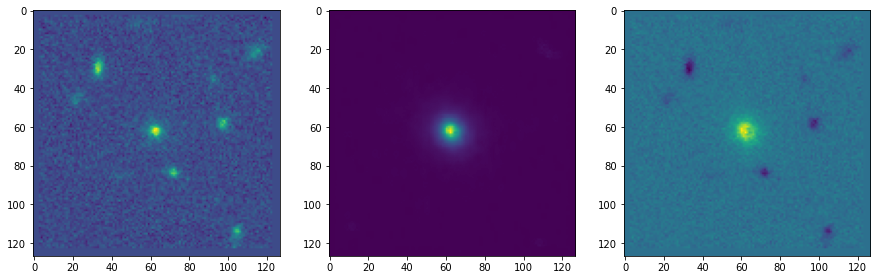

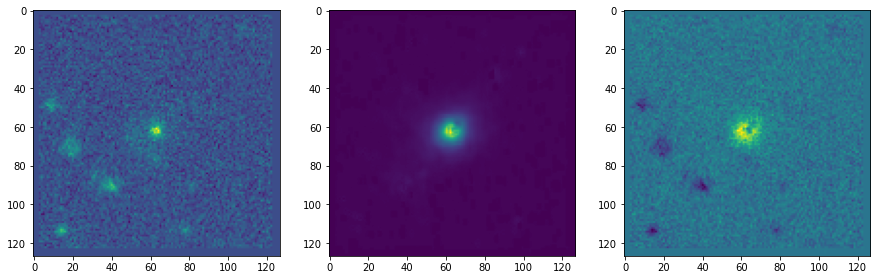

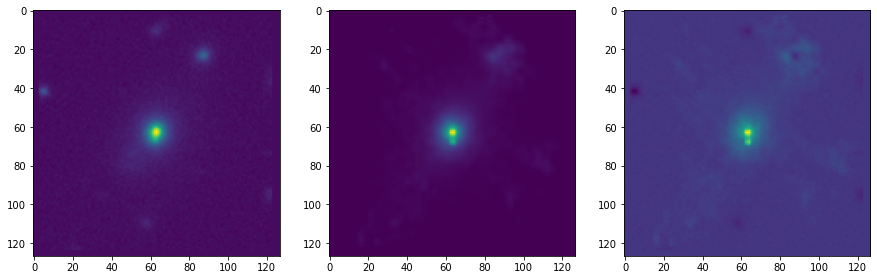

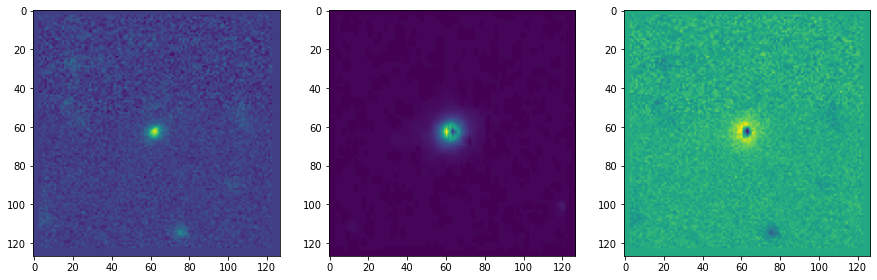

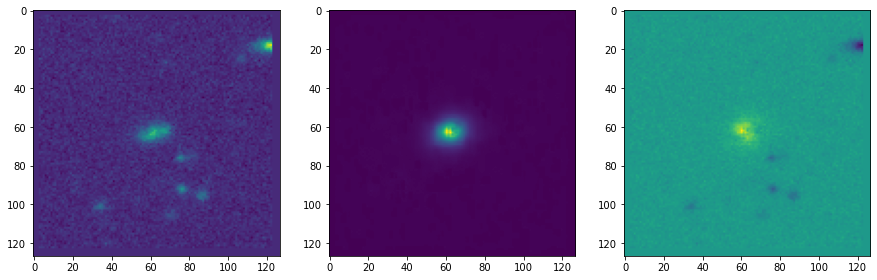

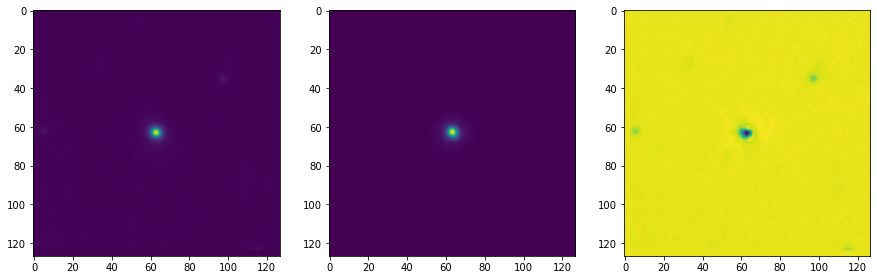

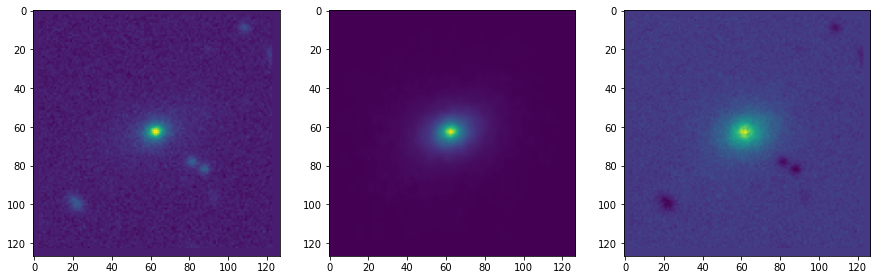

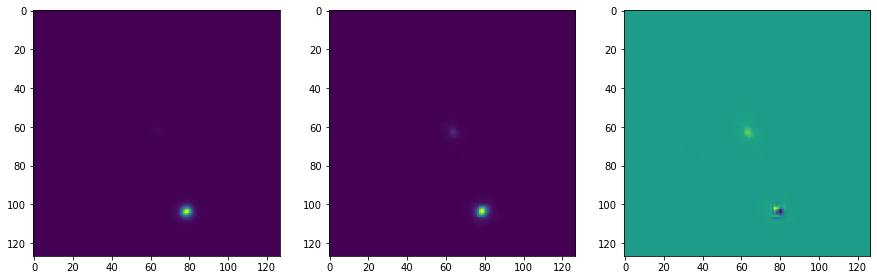

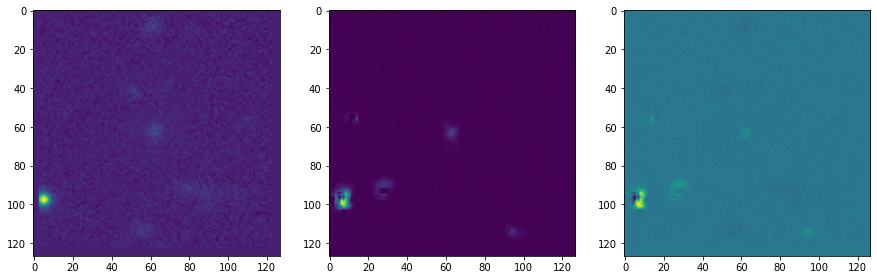

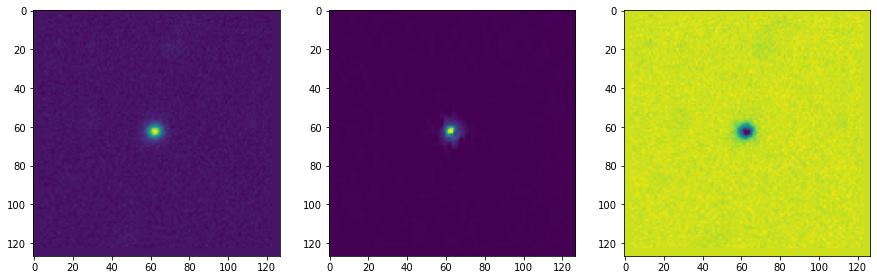

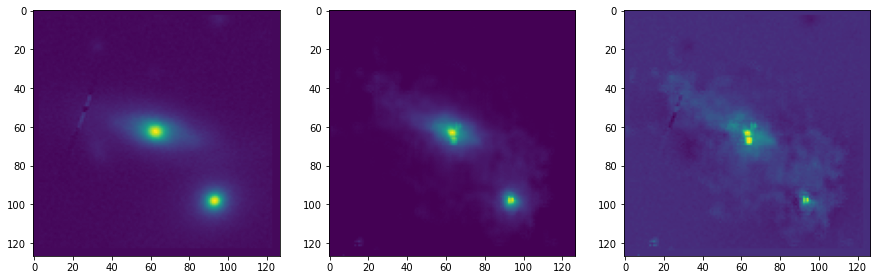

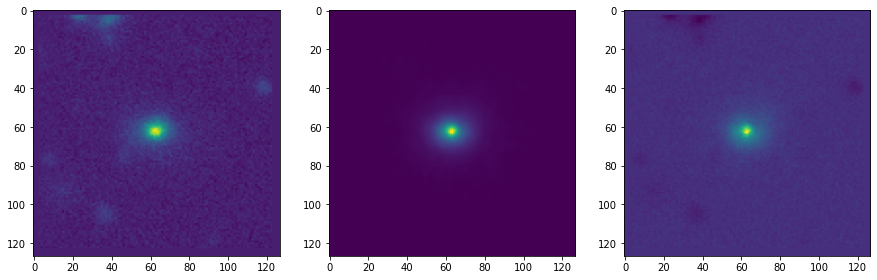

In [27]:
num_images = 12
with h5py.File(train_preds_path, 'r') as f:
    for i in range(num_images):
        # ONLY ONE BAND FOR NOW!!!
        fig, ax = plt.subplots(1,3, figsize=(15, 15))
        image = f['images'][i][0]
        prediction = f['preds'][i][0]
        diff = prediction - image
        ax[0].imshow(image)
        ax[1].imshow(prediction)
        ax[2].imshow(diff) # what the prediction is ADDING to the image.
        # note that imshow automatically converts hi-lo to 1-0 in images. can't figure out how to turn off

## Results

Reload previously saved model or saved results if you'd like to.

In [ ]:
savedmodel = tf.keras.models.load_model(dir_model, compile=False)
savedmodel.compile(optimizer='adam', loss='mse', metrics='mse')

### Example results

### Evaluate model